In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install pafy youtube-dl moviepy
!pip install imageio-ffmpeg
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 

%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 8.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 16.2 MB/s 


In [5]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [6]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
 
DATASET_DIR = "/content/drive/MyDrive/UCF50"
 
CLASSES_LIST = ["Biking", "JumpRope"]

In [7]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    video_reader.release()
    return frames_list

In [8]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')  
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  
    
    return features, labels, video_files_paths

In [9]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Biking
Extracting Data of Class: HighJump
Extracting Data of Class: HulaHoop
Extracting Data of Class: JumpRope


In [10]:
one_hot_encoded_labels = to_categorical(labels)

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [12]:
def create_convlstm_model():
  model = Sequential()
  model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                    IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(Flatten()) 
  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
  
  model.summary()
  
  return model

In [13]:
convlstm_model = create_convlstm_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

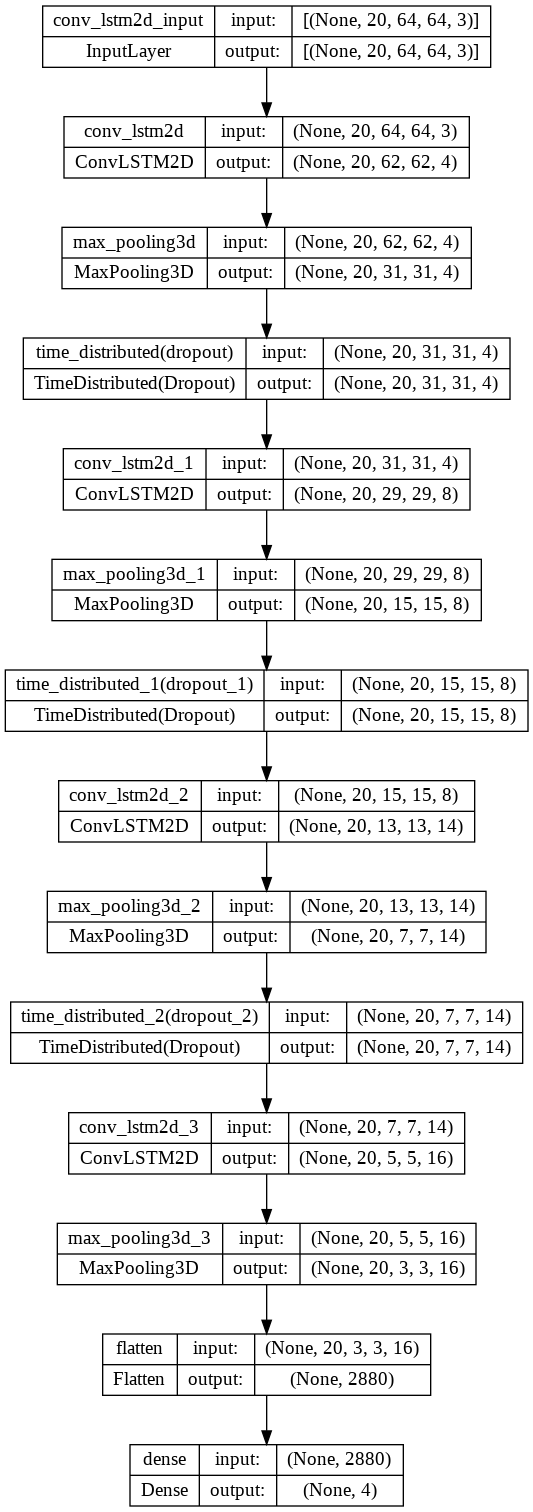

In [14]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [15]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train,
                                                     epochs = 20, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/20
81/81 [==============================] - 46s 354ms/step - loss: 1.3709 - accuracy: 0.2901 - val_loss: 1.4175 - val_accuracy: 0.2469
Epoch 2/20
81/81 [==============================] - 21s 257ms/step - loss: 1.2764 - accuracy: 0.4383 - val_loss: 1.3314 - val_accuracy: 0.3951
Epoch 3/20
81/81 [==============================] - 23s 286ms/step - loss: 0.9750 - accuracy: 0.6049 - val_loss: 0.9023 - val_accuracy: 0.6296
Epoch 4/20
81/81 [==============================] - 20s 245ms/step - loss: 0.6860 - accuracy: 0.7253 - val_loss: 1.1662 - val_accuracy: 0.5432
Epoch 5/20
81/81 [==============================] - 20s 241ms/step - loss: 0.5444 - accuracy: 0.7654 - val_loss: 1.0102 - val_accuracy: 0.6173
Epoch 6/20
81/81 [==============================] - 24s 300ms/step - loss: 0.4538 - accuracy: 0.8025 - val_loss: 0.8837 - val_accuracy: 0.7037
Epoch 7/20
81/81 [==============================] - 24s 290ms/step - loss: 0.4057 - accuracy: 0.8580 - val_loss: 0.6346 - val_accuracy: 0.7284

In [16]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

5/5 [==============================] - 1s 101ms/step - loss: 0.8748 - accuracy: 0.8382


In [17]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
convlstm_model.save(model_file_name)

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

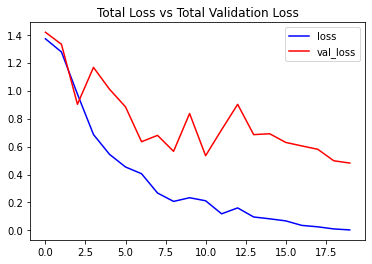

In [19]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

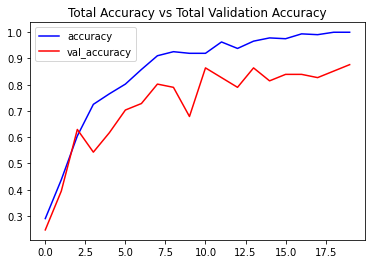

In [20]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [32]:
!pip install moviepy

!pip3 install imageio==2.4.1

!pip install --upgrade imageio-ffmpeg
from moviepy.editor import VideoFileClip
#https://stackoverflow.com/questions/55965507/runtimeerror-imageio-ffmpeg-download-has-been-deprecated-use-pip-install-im/73545896#73545896 then perform the steps given in answer 3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_list = []
    predicted_class_name = ''
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_list, axis = 0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
    video_reader.release()

In [34]:
input_video_file_path = f'/content/drive/MyDrive/BTP/v_Biking_g01_c03.mp4'
 
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)
 
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 66ms/step
Action Predicted: Biking
Confidence: 0.7884041666984558


 74%|███████▍  | 113/152 [00:00<00:00, 360.75it/s]WARNING:py.warnings:/usr/local/lib/python3.8/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/BTP/v_Biking_g01_c03.mp4, 360000 bytes wanted but 0 bytes read,at frame 151/152, at time 5.04/5.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

100%|██████████| 152/152 [00:00<00:00, 364.81it/s]
